In [74]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path


project_root = Path(os.getcwd())    # <-- or hard-code the root: Path(r"C:\…\PsychNet")
users_path   = project_root / 'movie_users.csv'
df_users     = pd.read_csv(users_path)

conv_path   = project_root / 'movie_conversations.csv'
df_conv     = pd.read_csv(conv_path)

urrs_path   = project_root / 'movie_utterances.csv'
df_utts     = pd.read_csv(urrs_path)



In [75]:
bechd_path   = project_root / 'bechdel_movies_2023_FEB.csv'
df_bechd     = pd.read_csv(bechd_path)

In [76]:
df_temp = df_utts[["utterance_id", "speaker", "reply_to", "movie_id"]]
df_edges_short = df_temp.merge(
    df_temp,
    left_on="reply_to",
    right_on="utterance_id",
    suffixes=('_1', '_2'),
    how='inner'
)

df_edges_short = df_edges_short[["speaker_1", "speaker_2", "movie_id_1"]]
df_edges_short


,speaker_1,speaker_2,movie_id_1
0,u0,u2,m0
1,u0,u2,m0
2,u0,u2,m0
3,u0,u2,m0
4,u2,u0,m0
...,...,...,...
221611,u9030,u9034,m616
221612,u9034,u9030,m616
221613,u9030,u9034,m616
221614,u9034,u9030,m616


In [77]:
df_edges = df_edges_short.merge(
    df_users,
    left_on="speaker_1",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_1', 'character_name':'character_name_1'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1"]]

In [78]:
df_edges = df_edges.merge(
    df_users,
    left_on="speaker_2",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_2', 'character_name':'character_name_2'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1", "gender_2", "character_name_2"]]

In [79]:
cols_to_lower = ['gender_1', 'gender_2']

df_edges[cols_to_lower] = df_edges[cols_to_lower].apply(lambda col: col.str.lower())


In [80]:
df_edges

,speaker_1,speaker_2,movie_id_1,gender_1,character_name_1,gender_2,character_name_2
0,u0,u2,m0,f,BIANCA,m,CAMERON
1,u0,u2,m0,f,BIANCA,m,CAMERON
2,u0,u2,m0,f,BIANCA,m,CAMERON
3,u0,u2,m0,f,BIANCA,m,CAMERON
4,u2,u0,m0,m,CAMERON,f,BIANCA
...,...,...,...,...,...,...,...
221611,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221612,u9034,u9030,m616,?,VEREKER,?,DURNFORD
221613,u9030,u9034,m616,?,DURNFORD,?,VEREKER
221614,u9034,u9030,m616,?,VEREKER,?,DURNFORD


In [81]:
df_meta = df_conv[["movie_idx", "movie_name", "release_year", "genre"]].drop_duplicates()

In [82]:
df_bechd['title'] = df_bechd['title'].apply(lambda col: col.lower())
df_meta['movie_name'] = df_meta['movie_name'].apply(lambda col: col.lower())
df_bechd['title'] = df_bechd['title'].replace(
    r'^(.*),\s*the$',   # match “anything”, comma, optional spaces, “The” at the end
    r'the \1',          # replace with “The” + space + the captured “anything”
    regex=True
)

In [83]:
df_bechd

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
0,passage de venus,1874,0,0.0,3155794,9602,18880,2021-04-02 20:58,1
1,la rosace magique,1877,0,0.0,14495706,9804,19145,2021-05-11 0:11,1
2,sallie gardner at a gallop,1878,0,0.0,2221420,9603,18882,2021-04-03 2:25,1
3,le singe musicien,1878,0,0.0,12592084,9806,19151,2021-05-11 23:38,1
4,athlete swinging a pick,1881,0,0.0,7816420,9816,19162,2021-05-13 1:32,1
...,...,...,...,...,...,...,...,...,...
9897,spider-man: no way home,2021,3,1.0,10872600,10166,19768,2021-12-21 02:14:30,1
9898,timeless,2018,3,0.0,5511582,10165,19766,2021-12-21 00:49:07,1
9899,red notice,2021,1,0.0,7991608,10164,19765,2021-12-20 14:10:11,1
9900,abbott and costello meet frankenstein,1948,3,0.0,40068,10163,19764,2021-12-19 18:11:42,1


In [84]:
df_meta['release_year'] = df_meta['release_year'].str.extract(r'(\d+)', expand=False)
df_meta['release_year'] = df_meta['release_year'].astype('Int64')
df_bechd['year'] = df_bechd['year'].astype('Int64')
df_meta = df_meta.merge(
    df_bechd,
    left_on=["movie_name", "release_year"],
    right_on=["title", "year"],
    how="inner",
)

df_meta = df_meta[["movie_idx", "movie_name", "release_year", "genre", "rating"]].drop_duplicates()


In [85]:
df_meta

,movie_idx,movie_name,release_year,genre,rating
0,m0,10 things i hate about you,1999,"['comedy', 'romance']",3
1,m3,2001: a space odyssey,1968,"['adventure', 'mystery', 'sci-fi']",0
2,m4,48 hrs.,1982,"['action', 'comedy', 'crime', 'drama', 'thrill...",2
3,m5,the fifth element,1997,"['action', 'adventure', 'romance', 'sci-fi', '...",1
4,m6,8mm,1999,"['crime', 'mystery', 'thriller']",1
...,...,...,...,...,...
406,m611,the world is not enough,1999,"['action', 'adventure', 'thriller']",2
407,m612,watchmen,2009,"['action', 'crime', 'fantasy', 'mystery', 'sci...",3
408,m613,xxx,2002,"['action', 'adventure', 'crime']",1
409,m614,x-men,2000,"['action', 'sci-fi']",1


In [86]:
df_meta = df_meta.rename(columns={'rating':'bechdel_score'})

In [87]:
import ast

df_meta['genre'] = df_meta['genre'].apply(ast.literal_eval)
df_meta

,movie_idx,movie_name,release_year,genre,bechdel_score
0,m0,10 things i hate about you,1999,"[comedy, romance]",3
1,m3,2001: a space odyssey,1968,"[adventure, mystery, sci-fi]",0
2,m4,48 hrs.,1982,"[action, comedy, crime, drama, thriller]",2
3,m5,the fifth element,1997,"[action, adventure, romance, sci-fi, thriller]",1
4,m6,8mm,1999,"[crime, mystery, thriller]",1
...,...,...,...,...,...
406,m611,the world is not enough,1999,"[action, adventure, thriller]",2
407,m612,watchmen,2009,"[action, crime, fantasy, mystery, sci-fi, thri...",3
408,m613,xxx,2002,"[action, adventure, crime]",1
409,m614,x-men,2000,"[action, sci-fi]",1


In [90]:
df_edges = df_edges.rename(columns={'movie_id_1': 'movie_id'})
df_meta = df_meta.rename(columns={'movie_idx': 'movie_id'})
meta_dict = df_meta.set_index('movie_id').to_dict(orient='index')
df_edges = df_edges[df_edges['movie_id'].isin(df_meta['movie_id'])]


df_grouped = (
    df_edges
      .groupby(['movie_id', 'speaker_1', 'speaker_2'])
      .size()
      .reset_index(name='weight')
)


In [91]:
graphs_by_movie = {}

for mid, sub_df in df_grouped.groupby('movie_id'):
    G = nx.Graph()

    df_this_movie_users = df_users[df_users['movie_idx'] == mid]
    id_to_name   = df_this_movie_users.set_index('user_id')['character_name'].to_dict()
    id_to_gender = df_this_movie_users.set_index('user_id')['gender'].to_dict()

    unique_speakers = set(sub_df['speaker_1']).union(sub_df['speaker_2'])

    for uid in unique_speakers:
        char_name = id_to_name.get(uid, uid)
        gender    = id_to_gender.get(uid, '?')
        G.add_node(uid,
                   character_name=char_name,
                   gender=gender)

    for _, row in sub_df.iterrows():
        u = row['speaker_1']
        v = row['speaker_2']
        w = row['weight']
        G.add_edge(u, v, weight=w)

    if mid in meta_dict:
        G.graph['movie_name']   = meta_dict[mid]['movie_name']
        G.graph['release_year'] = meta_dict[mid]['release_year']
        G.graph['genre']        = meta_dict[mid]['genre']
        G.graph['bechdel_score']= meta_dict[mid]['bechdel_score']
    else:
        G.graph['movie_name']   = None
        G.graph['release_year'] = None
        G.graph['genre']        = None
        G.graph['bechdel_score']= None

    # 3.e  Store this graph in the dictionary
    graphs_by_movie[mid] = G

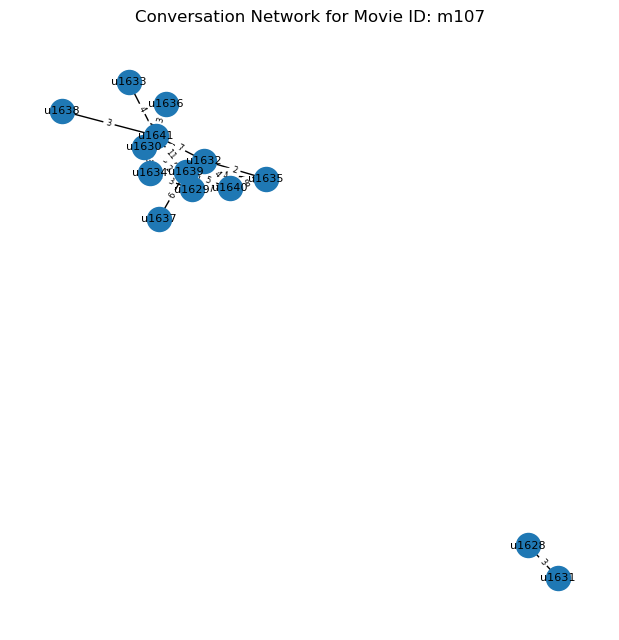

In [92]:
# 5b. Visualize the graph for the first movie_id as an example
first_movie_id = list(graphs_by_movie.keys())[5]
G_example = graphs_by_movie[first_movie_id]

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_example, seed=42)  # seed for reproducibility
nx.draw(
    G_example,
    pos,
    with_labels=True,
    node_size=300,
    font_size=8
)
edge_labels = nx.get_edge_attributes(G_example, 'weight')
nx.draw_networkx_edge_labels(
    G_example,
    pos,
    edge_labels=edge_labels,
    font_size=6
)
plt.title(f"Conversation Network for Movie ID: {first_movie_id}")
plt.show()

Print graph by Movie_id

In [111]:
import matplotlib.pyplot as plt

def plot_movie_graph_with_node_attrs(movie_id):
    if movie_id not in graphs_by_movie:
        print(f"No graph found for movie_id {movie_id}")
        return

    G = graphs_by_movie[movie_id]
    movie_name = G.graph.get('movie_name', 'Unknown')
    node_colors = []
    labels = {}

    for uid, attrdict in G.nodes(data=True):
        gender = attrdict.get('gender', '?').lower()
        if gender == 'f':
            node_colors.append('#ff69b4')
        elif gender == 'm':
            node_colors.append('#1f77b4')
        else:
            node_colors.append('gray')

        labels[uid] = attrdict.get('character_name', uid)

    # Plot:
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, alpha=0.7)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.title(f"Conversation Graph for \"{movie_name}\"", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [112]:
mid = df_conv["movie_idx"].sample(n=1).iloc[0]
plot_movie_graph_with_node_attrs(mid)

No graph found for movie_id m390


In [73]:
df_conv[df_conv["movie_idx"] == mid]

,conversation_id,movie_idx,movie_name,release_year,rating,votes,genre
22758,L444535,m160,plastic man,1999,6.7,29,['drama']
22759,L444521,m160,plastic man,1999,6.7,29,['drama']
22760,L444075,m160,plastic man,1999,6.7,29,['drama']
22761,L443994,m160,plastic man,1999,6.7,29,['drama']
22762,L444462,m160,plastic man,1999,6.7,29,['drama']
...,...,...,...,...,...,...,...
22907,L443932,m160,plastic man,1999,6.7,29,['drama']
22908,L443930,m160,plastic man,1999,6.7,29,['drama']
22909,L444275,m160,plastic man,1999,6.7,29,['drama']
22910,L443919,m160,plastic man,1999,6.7,29,['drama']
